# Big Data (UBA) -  2024

## Trabajo Práctico 4

### Fecha de entrega:




<font color='red'> Viernes 13 de Diciembre a las 13:00 hs </font>

In [22]:
# Instalacion de paquetes/librerias
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import locale
import datetime
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Parte I: Análisis de la base de hogares y tipo de ocupación

#### 1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen pueden ser predictivas de la desocupación y seria útil incluir para perfeccionar el ejercicio del TP3? Mencionen estas variables y justifiquen su elección.

Todas las variables que caracterice el tipo de hogar y su construccon pueden ayudar a perfeccionar la estimacion de desocupados (u ocupados) al funcionar como un proxy de status socioeconomico. Especilamente las que estan presente en la construccion de las metrica de pobreza sobre Necesidades Basicas Insatisfechas (baño, numero de habitaciones, condiciones de hacinamiento). Ademas, se podria incorporar las variables de la seccion "¿En los últimos tres meses, las personas de este hogar han vivido...": muchas preguntan indagan directamente por los ingresos del hogar. En caso de no tener nulos, podria dotar al modelo de un significativo poder explicativo. Por ultimo, la cantidad de miembros del hogar y si posee servicio domestico parecen ser otras dos buenas complementaciones.

#### 2.	Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2004 y 2024 en formato .dta y .xls, respectivamente. La base de hogares se llama Hogar_t104.dta y usu_hogar_T124.xls, respectivamente. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciuidad Autónoma de Buenos Aires o Gran Buenos Aires y unan ambos trimestres en una sola base. Esto es, a la base de la encuesta individual de cada año (que usaron en el TP3) unan la base de la encuesta de hogar. Asegúrese de estar usando las variables CODUSU y NRO_Hogar para el merge.

In [2]:
# Leer la base de datos para 2004 (archivo .dta)
df_2004 = pd.read_stata('/content/Hogar_t104.dta')

# Leer la base de datos para 2024 (archivo .xls)
df_2024 = pd.read_excel('/content/usu_hogar_T124.xlsx')

# Leer la base de datos del TP3 (archivo .xls)
df_2004_2024_caba_gba_ind = pd.read_excel('/content/df_2004_2024_caba_gba_ind.xlsx')

In [3]:
# Modificamos ciertas cuestiones para poder hacer el merge entre bases.
# Mas especificamente, la adaptamos la base 2004 al formato de la 2024

## Paso las variables de 2004 a mayusculas para que haga el concat de manera correcta

df_2004.columns = df_2004.columns.str.upper()

## Algunas variables de la EPH 2004 tienen datos en STR. Las paso al mismo codigo numerico
## que la EPH 2024

### Cambiar "Si" a 1 y "No" a 0
df_2004.replace({'Si': 1, 'Sí': 1, 'No': 2}, inplace=True)

df_2004_2024_caba_gba_ind.replace({'Si': 1, 'Sí': 1, 'No': 2}, inplace=True)

### Cambiar valores específicos para "Servicio doméstico"
df_2004.replace({'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98
}, inplace=True)


df_2004_2024_caba_gba_ind.replace({'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98
}, inplace=True)

### Diccionarios de reemplazo

### AGLOMERADO
cambios_aglomerado = {
    "Gran La Plata": 2, "Bahía Blanca - Cerri": 3, "Gran Rosario": 4, "Gran Santa Fé": 5,
    "Gran Paraná": 6, "Posadas": 7, "Gran Resistencia": 8, "Cdro. Rivadavia – Rada Tilly": 9,
    "Gran Mendoza": 10, "Corrientes": 12, "Gran Córdoba": 13, "Concordia": 14,
    "Formosa": 15, "Neuquén – Plottier": 17, "S.del Estero - La Banda": 18,
    "Jujuy - Palpalá": 19, "Río Gallegos": 20, "Gran Catamarca": 22, "Salta": 23,
    "La Rioja": 25, "San Luis - El Chorrillo": 26, "Gran San Juan": 27,
    "Gran Tucumán - T. Viejo": 29, "Santa Rosa - Toay": 30, "Ushuaia - Río Grande": 31,
    "Ciudad de Buenos Aires": 32, "Partidos del GBA": 33, "Mar del Plata - Batán": 34,
    "Río Cuarto": 36
}

### IV1
cambios_iv1 = {
    "Casa": 1, "Departamento": 2, "Pieza de inquilinato": 3,
    "Pieza en hotel / pensión": 4, "Local no construido para habitación": 5, "Otros": 6
}

### IV3
cambios_iv3 = {
    "Mosaico / baldosa / madera / cerámica / alfombra": 1, "Cemento / ladrillo fijo": 2,
    "Ladrillo suelto / tierra": 3, "Otro": 4
}

### IV4
cambios_iv4 = {
    "Membrana / cubierta asfáltica": 1, "Baldosa / losa sin cubierta": 2, "Pizarra / teja": 3,
    "Chapa de metal sin cubierta": 4, "Chapa de fibrocemento / plástico": 5,
    "Chapa de cartón": 6, "Caña / tabla / paja con barro / paja sola": 7,
    "N/S. Depto en propiedad horizontal": 9
}

### IV6
cambios_iv6 = {
    "Por cañería dentro de la vivienda": 1,
    "Fuera de la vivienda pero dentro del terreno": 2,
    "Fuera del terreno": 3
}

### IV7
cambios_iv7 = {
    "Red pública (agua corriente)": 1, "Perforación con bomba a motor": 2,
    "Perforación con bomba manual": 3, "Otra fuente": 4
}

### IV9
cambios_iv9 = {
    "Dentro de la vivienda": 1,
    "Fuera de la vivienda pero dentro del terreno": 2,
    "Fuera del terreno": 3
}

### IV10
cambios_iv10 = {
    "Inodoro con botón / mochila / cadena y arrastre de agua": 1,
    "Inodoro sin botón / cadena y con arrastre de agua (a balde)": 2,
    "Letrina (sin arrastre de agua)": 3
}

### IV11
cambios_iv11 = {
    "A red pública (cloaca)": 1, "A cámara séptica y pozo ciego": 2,
    "Sólo a pozo ciego": 3, "A hoyo / excavación en la tierra": 4
}

### II7
cambios_ii7 = {
    "Propietario de la vivienda y el terreno": 1, "Propietario de la vivienda solamente": 2,
    "Inquilino / arrendatario de la vivienda": 3, "Ocupante por pago de impuestos / expensas": 4,
    "Ocupante en relación de dependencia": 5, "Ocupante gratuito (con permiso)": 6,
    "Ocupante de hecho (sin permiso)": 7, "Está en sucesión": 8, "Otra situación": 9
}

### II8
cambios_ii8 = {
    "Gas de red": 1, "Gas de tubo / garrafa": 2,
    "Kerosene / leña/ carbón": 3, "Otro": 4
}

### II9
cambios_ii9 = {
    "Uso exclusivo del hogar": 1,
    "Compartido con otro/s hogar/es de la misma vivienda": 2,
    "Compartido con otra/s vivienda/s": 3,
    "No tiene baño": 4
}

df_2004['AGLOMERADO'].replace(cambios_aglomerado, inplace=True)
df_2004['IV1'].replace(cambios_iv1, inplace=True)
df_2004['IV3'].replace(cambios_iv3, inplace=True)
df_2004['IV4'].replace(cambios_iv4, inplace=True)
df_2004['IV6'].replace(cambios_iv6, inplace=True)
df_2004['IV7'].replace(cambios_iv7, inplace=True)
df_2004['IV9'].replace(cambios_iv9, inplace=True)
df_2004['IV10'].replace(cambios_iv10, inplace=True)
df_2004['IV11'].replace(cambios_iv11, inplace=True)
df_2004['II7'].replace(cambios_ii7, inplace=True)
df_2004['II8'].replace(cambios_ii8, inplace=True)
df_2004['II9'].replace(cambios_ii9, inplace=True)

# Filtrar las observaciones para CABA (AGLOMERADO = 32) y GBA (AGLOMERADO = 33) en 2004 y 2024

df_2004_caba_gba = df_2004[df_2004['AGLOMERADO'].isin([32,33])]

df_2024_caba_gba = df_2024[df_2024['AGLOMERADO'].isin([32,33])]

# Unir ambos trimestres de la EPH Hogar

df_2004_2024_caba_gba_hog = pd.concat([df_2004_caba_gba, df_2024_caba_gba], ignore_index=True)

# Unir la EPH Hogar con la EPH Individuo, para iguales trimestres de
# 2004 y 2024, respectivamente.

df_2004_2024_caba_gba = pd.merge(df_2004_2024_caba_gba_ind, df_2004_2024_caba_gba_hog, on=["CODUSU", "NRO_HOGAR"
], how="inner")

<ipython-input-3-1e4643f199b3>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2004.replace({'Si': 1, 'Sí': 1, 'No': 2}, inplace=True)
<ipython-input-3-1e4643f199b3>:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_2004.replace({'Si': 1, 'Sí': 1, 'No': 2}, inplace=True)
<ipython-input-3-1e4643f199b3>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('

#### 3.	Limpien la base de datos tomando criterios que hagan sentido. Explicar cualquier decisión como el tratamiento de valores faltantes (missing values), extremos (outliers), o variables categóricas. Justifique sus decisiones.

In [4]:
# La primera limpieza necesaria es eliminar las columnas que terminana en "_x" y
# dejar las de "_y". Ambas eran variables iguales y me quedo con las de hogar porque son de
# formato float64.

# Eliminar todas las columnas que terminan en '_x'
df_2004_2024_caba_gba_fil = df_2004_2024_caba_gba[[col for col in df_2004_2024_caba_gba.columns if not col.endswith('_x')]]

# Renombrar las columnas que terminan en '_y' para quitar el sufijo
df_2004_2024_caba_gba_fil.columns = [col[:-2] if col.endswith('_y') else col for col in df_2004_2024_caba_gba_fil.columns]

# Limpiar la cantidad de ambientes mayores a 11
# Eliminar la cantidad de miembros del hogar mayores a 10
# Edad mayor a cero

# Eliminar filas donde 'IV2' > 11
df_2004_2024_caba_gba_fil = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['IV2'] <= 11]

# Eliminar filas donde 'IX_TOT' > 10
df_2004_2024_caba_gba_fil = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['IX_TOT'] <= 10]

# Eliminar filas donde 'CH06' <= 0
df_2004_2024_caba_gba_fil = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['CH06'] > 0]



#### 4.	Construya variables (mínimo 3) que no estén en la base pero que sean relevantes para predecir individuos desocupados (por ejemplo, la proporción de personas que trabajan en el hogar).

In [5]:
# Adultos mayores en el hogar

## Filtrar los miembros mayores a 65 años
df_mayores_65 = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['CH06'] > 65]

## Agrupar por 'CODUSU' y 'NRO_HOGAR' y contar la cantidad de personas mayores a 65
df_mayores_65_count = df_mayores_65.groupby(['CODUSU', 'NRO_HOGAR']).size().reset_index(name='MIEMBROS_MAYORES_65')

## Unir el conteo al DataFrame original (para agregar la nueva columna)
df_2004_2024_caba_gba_fil = pd.merge(df_2004_2024_caba_gba_fil, df_mayores_65_count, on=['CODUSU', 'NRO_HOGAR'], how='left')

## Rellenar los valores NaN con 0 y convertir la columna a tipo int
df_2004_2024_caba_gba_fil['MIEMBROS_MAYORES_65'] = df_2004_2024_caba_gba_fil['MIEMBROS_MAYORES_65'].fillna(0).astype(int)

# Dummy si el hogar recibe alguna transferencia del estado

df_2004_2024_caba_gba_fil['AYUDA_GOBIERNO'] = (
    (df_2004_2024_caba_gba_fil[['V1', 'V2', 'V21', 'V22', 'V5']] == 1).any(axis=1).astype(int)
)

df_2004_2024_caba_gba_fil['AYUDA_GOBIERNO1'] = (
    (df_2004_2024_caba_gba_fil[['V4', 'V5']] == 1).any(axis=1).astype(int)
)

# Niños en primera infancia en el hogar

df_menores_6 = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['CH06'] < 6]
df_menores_6_count = df_menores_6.groupby(['CODUSU', 'NRO_HOGAR']).size().reset_index(name='MIEMBROS_MENORES_6')
df_2004_2024_caba_gba_fil = pd.merge(df_2004_2024_caba_gba_fil, df_menores_6_count, on=['CODUSU', 'NRO_HOGAR'], how='left')
df_2004_2024_caba_gba_fil['MIEMBROS_MENORES_6'] = df_2004_2024_caba_gba_fil['MIEMBROS_MENORES_6'].fillna(0).astype(int)


5.	Presenten estadísticas descriptivas de tres variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir la desocupación. Comenten las estadísticas obtenidas.

i. Número de adultos mayores

In [6]:
# Agregar la columna PEA (Población Económicamente Activa)
df_2004_2024_caba_gba_fil['PEA'] = df_2004_2024_caba_gba_fil['ESTADO'].apply(lambda x: 1 if x in [1, 2] else 0)

In [7]:
# Agregar la columna desocupado
df_2004_2024_caba_gba_fil['desocupado'] = df_2004_2024_caba_gba_fil['ESTADO'].apply(lambda x: 1 if x == 2 else 0)

In [8]:
# Crea una base de datos unicos
uni=df_2004_2024_caba_gba_fil.groupby(['CODUSU', 'NRO_HOGAR']).first()
# Valor promedio de adultos mayores en los hogares
# Solo se considera a los hogares que tienen al menos un adulto mayor en el hogar
uni[uni['MIEMBROS_MAYORES_65']>0].groupby('ANO4')['MIEMBROS_MAYORES_65'].mean()

,MIEMBROS_MAYORES_65
ANO4,
2004.0,1.327640
2024.0,1.306202


In [9]:
#Porcentaje de encuestados según cantidad de adultos mayores de 65 años en sus hogares
df_2004_2024_caba_gba_fil.groupby('ANO4')['MIEMBROS_MAYORES_65'].value_counts(normalize=True)*100

ANO4    MIEMBROS_MAYORES_65
2004.0  0                      79.530068
        1                      13.673171
        2                       6.517988
        3                       0.278773
2024.0  0                      75.248094
        1                      16.079390
        2                       8.485546
        3                       0.186970
Name: proportion, dtype: float64

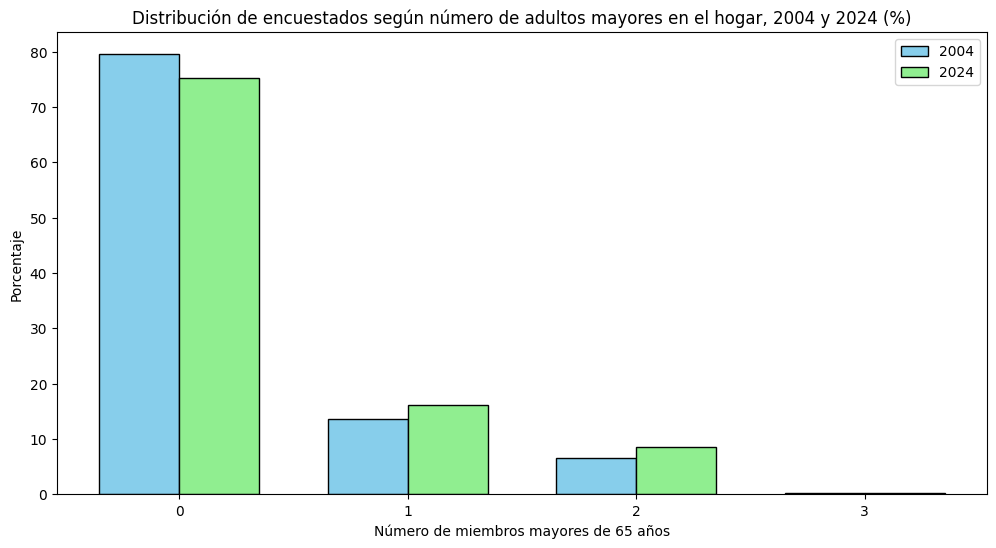

In [10]:
# Datos para el año 2004 (calcular porcentajes)
data_2004 = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['ANO4'] == 2004]['MIEMBROS_MAYORES_65'].value_counts(normalize=True) * 100

# Datos para el año 2024 (calcular porcentajes)
data_2024 = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['ANO4'] == 2024]['MIEMBROS_MAYORES_65'].value_counts(normalize=True) * 100

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Ancho de las barras
bar_width = 0.35
index = range(len(data_2004))  # Índices para las barras

# Gráfico para 2004
plt.bar(index, data_2004, bar_width, color='skyblue', edgecolor='black', label='2004')

# Gráfico para 2024 desplazado
plt.bar([i + bar_width for i in index], data_2024, bar_width, color='lightgreen', edgecolor='black', label='2024')

# Etiquetas y título
plt.title('Distribución de encuestados según número de adultos mayores en el hogar, 2004 y 2024 (%)')
plt.xlabel('Número de miembros mayores de 65 años')
plt.ylabel('Porcentaje')

# Ajuste de los ejes x
plt.xticks([i + bar_width / 2 for i in index], data_2004.index)

# Leyenda
plt.legend()

# Mostrar la cuadrícula
plt.grid(False)

# Mostrar el gráfico
plt.show()


In [11]:
# Proporción de encuestados según situacion de ocupación y cantidad de adultos mayores residentes en el hogar
df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['PEA'] == 1].groupby(['ANO4','desocupado'])['MIEMBROS_MAYORES_65'].value_counts(normalize=True)*100

ANO4    desocupado  MIEMBROS_MAYORES_65
2004.0  0           0                      86.250000
                    1                      10.526316
                    2                       3.092105
                    3                       0.131579
        1           0                      85.741445
                    1                      11.787072
                    2                       2.091255
                    3                       0.380228
2024.0  0           0                      84.205607
                    1                      11.619938
                    2                       4.143302
                    3                       0.031153
        1           0                      82.636656
                    1                      12.540193
                    2                       4.823151
Name: proportion, dtype: float64

ii. Encuestados que reciben ayudan del gobierno

In [135]:
# Proporción de encuestados según si reciben una transferencia del Estado
df_2004_2024_caba_gba_fil.groupby(['ANO4'])['AYUDA_GOBIERNO1'].value_counts(normalize=True)*100

ANO4    AYUDA_GOBIERNO1
2004.0  0                  93.229789
        1                   6.770211
2024.0  0                  81.993384
        1                  18.006616
Name: proportion, dtype: float64

In [13]:
# Proporción de encuestados según situación de desocupación y si reciben una transferencia del Estado
df_2004_2024_caba_gba_fil[(df_2004_2024_caba_gba_fil['PEA'] == 1)].groupby(['ANO4','desocupado'])['AYUDA_GOBIERNO1'].value_counts(normalize=True)*100

ANO4    desocupado  AYUDA_GOBIERNO1
2004.0  0           0                  95.296053
                    1                   4.703947
        1           0                  88.022814
                    1                  11.977186
2024.0  0           0                  86.292835
                    1                  13.707165
        1           0                  77.813505
                    1                  22.186495
Name: proportion, dtype: float64

Número de niños en primera infancia

In [14]:
# Valor promedio de numero de niños en primera infancia en los hogares
# Solo se considera a los hogares que tienen niños en primera infancia en el hogar
uni[(uni['MIEMBROS_MENORES_6']>0) & (uni['MIEMBROS_MENORES_6']<4)].groupby('ANO4')['MIEMBROS_MENORES_6'].mean()

,MIEMBROS_MENORES_6
ANO4,
2004.0,1.329114
2024.0,1.184300


In [15]:
#Porcentaje de encuestados según cantidad de menores de 6 años en sus hogares
df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['MIEMBROS_MENORES_6']<4].groupby('ANO4')['MIEMBROS_MENORES_6'].value_counts(normalize=True)*100

ANO4    MIEMBROS_MENORES_6
2004.0  0                     65.749601
        1                     22.873472
        2                      9.356725
        3                      2.020202
2024.0  0                     80.684597
        1                     15.058248
        2                      3.609953
        3                      0.647203
Name: proportion, dtype: float64

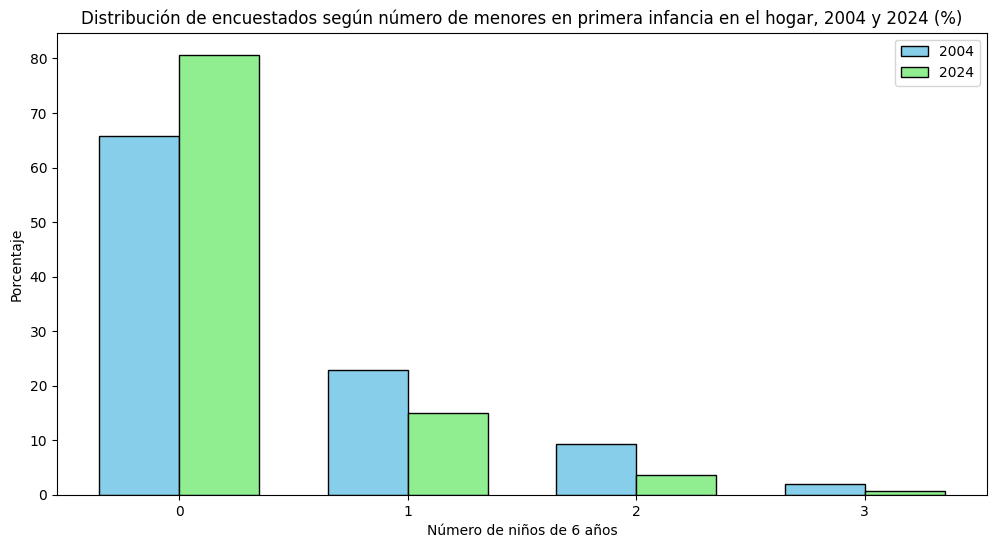

In [16]:
# Datos para el año 2004 (calcular porcentajes)
data_2004 = df_2004_2024_caba_gba_fil[(df_2004_2024_caba_gba_fil['ANO4'] == 2004) & (df_2004_2024_caba_gba_fil['MIEMBROS_MENORES_6'] < 4)]['MIEMBROS_MENORES_6'].value_counts(normalize=True) * 100

# Datos para el año 2024 (calcular porcentajes)
data_2024 = df_2004_2024_caba_gba_fil[df_2004_2024_caba_gba_fil['ANO4'] == 2024]['MIEMBROS_MENORES_6'].value_counts(normalize=True) * 100

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Ancho de las barras
bar_width = 0.35
index = range(len(data_2004))  # Índices para las barras

# Gráfico para 2004
plt.bar(index, data_2004, bar_width, color='skyblue', edgecolor='black', label='2004')

# Gráfico para 2024 desplazado
plt.bar([i + bar_width for i in index], data_2024, bar_width, color='lightgreen', edgecolor='black', label='2024')

# Etiquetas y título
plt.title('Distribución de encuestados según número de menores en primera infancia en el hogar, 2004 y 2024 (%)')
plt.xlabel('Número de niños de 6 años')
plt.ylabel('Porcentaje')

# Ajuste de los ejes x
plt.xticks([i + bar_width / 2 for i in index], data_2004.index)

# Leyenda
plt.legend()

# Mostrar la cuadrícula
plt.grid(False)

# Mostrar el gráfico
plt.show()


In [17]:
# Proporción de encuestados según situación de ocupación y número de niños menores de 6 años en el hogar
df_2004_2024_caba_gba_fil[(df_2004_2024_caba_gba_fil['PEA'] == 1) & (df_2004_2024_caba_gba_fil['MIEMBROS_MENORES_6'] < 4)].groupby(['ANO4','desocupado'])['MIEMBROS_MENORES_6'].value_counts(normalize=True)*100

ANO4    desocupado  MIEMBROS_MENORES_6
2004.0  0           0                     70.958182
                    1                     20.941719
                    2                      7.079355
                    3                      1.020744
        1           0                     73.384030
                    1                     18.821293
                    2                      6.273764
                    3                      1.520913
2024.0  0           0                     85.233645
                    1                     12.118380
                    2                      2.242991
                    3                      0.404984
        1           0                     83.601286
                    1                     13.504823
                    2                      2.572347
                    3                      0.321543
Name: proportion, dtype: float64

II. Clasificación

1.	Para cada año, partan la base respondieron en una base de prueba y una de entrenamiento (X_train, y_train, X_test, y_test) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 101. Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [136]:
respondieron04 = df_2004_2024_caba_gba_fil[(df_2004_2024_caba_gba_fil['ANO4'] == 2004) & (df_2004_2024_caba_gba_fil['PEA'] == 1)]
respondieron24 = df_2004_2024_caba_gba_fil[(df_2004_2024_caba_gba_fil['ANO4'] == 2024) & (df_2004_2024_caba_gba_fil['PEA'] == 1)]
respondieron04r = respondieron04[['desocupado','CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'IPCF','MIEMBROS_MAYORES_65','AYUDA_GOBIERNO1','MIEMBROS_MENORES_6']]
respondieron24r = respondieron24[['desocupado','CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'IPCF','MIEMBROS_MAYORES_65','AYUDA_GOBIERNO1','MIEMBROS_MENORES_6']]

Para el año 2004

In [137]:
x_04=respondieron04r.drop('desocupado', axis=1)
y_04=respondieron04r['desocupado']
x_train04, x_test04, y_train04, y_test04 = train_test_split(x_04, y_04, test_size=0.3, random_state=101)
x_train1_04=sm.add_constant(x_train04)
x_test1_04=sm.add_constant(x_test04)

Para el año 2024

In [138]:
x_24=respondieron24r.drop('desocupado', axis=1)
y_24=respondieron24r['desocupado']
x_train24, x_test24, y_train24, y_test24 = train_test_split(x_24, y_24, test_size=0.3, random_state=101)
x_train1_24=sm.add_constant(x_train24)
x_test1_24=sm.add_constant(x_test24)

2. Expliquen brevemente cómo elegirían λ por validación cruzada (en Python es alpha). Detallen por qué no usarían el conjunto de prueba (test) para su elección

Los valores de λ pueden hallarse mediante un Grid Search o un Random Search. En el primero, se asigna un rango de valores, así como un intervalo definido entre cada número y se estima el modelo para cada uno de estos valores, considerando como óptimo el que minimice algun criterio de penalización. Mientras que en el segundo, se brinda solo un intervalo de números y se realiza las estimaciones con cualquier número elegido aleatoriamente, pero que pertenezca a dicho intervalo.

El conjunto de prueba se debe reservar únicamente para evaluar el rendimiento final del modelo después de seleccionar todos los hiperparámetros, incluido λ. Si se utilizara el conjunto de prueba para elegir λ, estaríamos introduciendo sesgo en el proceso de selección de parámetros, ya que el modelo estaría “viendo” los datos de prueba durante el ajuste de hiperparámetros. Esto haría que el desempeño del modelo en el conjunto de prueba no reflejara realmente su capacidad de generalización a datos nuevos, pues el modelo ya habría sido ajustado indirectamente para tener un buen rendimiento en esos datos.

3.	En validación cruzada, ¿cuáles son las implicancias de usar un k muy pequeño o uno muy grande? Cuando k = n (con n el número de muestras), ¿cuántas veces se estima el modelo?

El valor de K (subcobjuntos de muestreo) es importante porque un valor reducido puede generar un mayor riesgo de sobreajuste, ya que puede ajustarse a las particularidades de los datos de entrenamiento. Sin embargo, esto tiene asociado un menor costo computacional. En contraste, elegir un valor elevado de K, disminuye las probabilidades de sobreajutes, pero usa de forma intensiva recursos computacionales.

En el extremo, podría considerarse K=N, es decir, que se realicen tantos subconjuntos como cantidad de datos con los que se cuenta. De esta forma, se estima el modelo N veces con N-1 datos asegurando que al menos un dato haya sido considerado, alguna vez, como parte del conjunto de prueba o lo que es lo mismo que, alguna vez, un dato no haya formado parte del conjunto de prueba.

4. 	Para regresión logística, implementen la penalidad, L1 como la de LASSO y L2 como la de Ridge con λ=1 (como en la Tutorial 10), usando la opción penalty y reporten la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy para cada año.  ¿Cómo cambiaron los resultados con respecto al TP3? ¿La performance de regresión logística con regularización es mejor o peor?

Para 2004

Con penalty=l1

In [139]:
# Regresión logística
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear').fit(x_train1_04, y_train04)
y_test_pred_score = log_reg_l1.predict_proba(x_test1_04)[:,1]
y_test_pred = log_reg_l1.predict(x_test1_04)

In [140]:
#Matrix de confusión
matriz_confusion = confusion_matrix(y_test04, y_test_pred)
print('Confusion Matrix:')
print(matriz_confusion)

Confusion Matrix:
[[893   7]
 [159  11]]


In [141]:
#AUC valor
auc = roc_auc_score(y_test04, y_test_pred)
print('AUC: %.2f' % auc)

AUC: 0.53


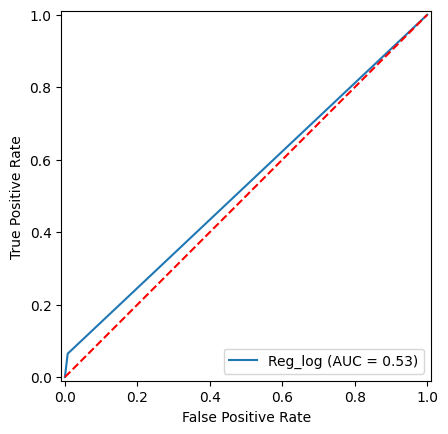

In [142]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test04, y_test_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

In [143]:
#Accuracy
accuracy = accuracy_score(y_test04, y_test_pred)
print("La accuracy del modelo es: %.3f" %accuracy)

La accuracy del modelo es: 0.845


Con penalty=l2

In [144]:
# Regresión logística
log_reg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, C=1).fit(x_train1_04, y_train04)
y_test_pred_score = log_reg_l2.predict_proba(x_test1_04)[:,1]
y_test_pred = log_reg_l2.predict(x_test1_04)

In [145]:
#Matrix de confusión
matriz_confusion = confusion_matrix(y_test04, y_test_pred)
print('Confusion Matrix:')
print(matriz_confusion)

Confusion Matrix:
[[893   7]
 [158  12]]


In [146]:
#AUC valor
auc = roc_auc_score(y_test04, y_test_pred)
print('AUC: %.2f' % auc)

AUC: 0.53


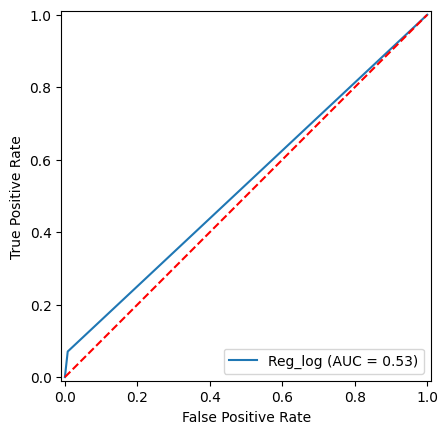

In [147]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test04, y_test_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

In [148]:
#Accuracy
accuracy = accuracy_score(y_test04, y_test_pred)
print("La accuracy del modelo es: %.3f" %accuracy)

La accuracy del modelo es: 0.846


Para 2024

Con penalty=l1

In [83]:
# Regresión logística
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear').fit(x_train1_24, y_train24)
y_test_pred_score = log_reg_l1.predict_proba(x_test1_24)[:,1]
y_test_pred = log_reg_l1.predict(x_test1_24)

In [84]:
#Matrix de confusión
matriz_confusion = confusion_matrix(y_test24, y_test_pred)
print('Confusion Matrix:')
print(matriz_confusion)

Confusion Matrix:
[[960   2]
 [ 94   1]]


In [85]:
#AUC valor
auc = roc_auc_score(y_test24, y_test_pred)
print('AUC: %.2f' % auc)

AUC: 0.50


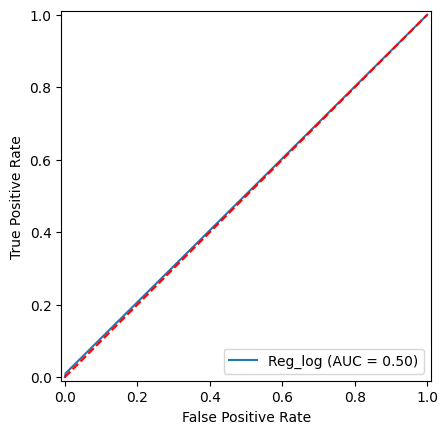

In [86]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test24, y_test_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

In [87]:
#Accuracy
accuracy = accuracy_score(y_test24, y_test_pred)
print("La accuracy del modelo es: %.3f" %accuracy)

La accuracy del modelo es: 0.909


Con penalty=l2

In [88]:
# Regresión logística
log_reg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, C=1).fit(x_train1_24, y_train24)
y_test_pred_score = log_reg_l2.predict_proba(x_test1_24)[:,1]
y_test_pred = log_reg_l2.predict(x_test1_24)

In [89]:
#Matrix de confusión
matriz_confusion = confusion_matrix(y_test24, y_test_pred)
print('Confusion Matrix:')
print(matriz_confusion)

Confusion Matrix:
[[959   3]
 [ 94   1]]


In [90]:
#AUC valor
auc = roc_auc_score(y_test24, y_test_pred)
print('AUC: %.2f' % auc)

AUC: 0.50


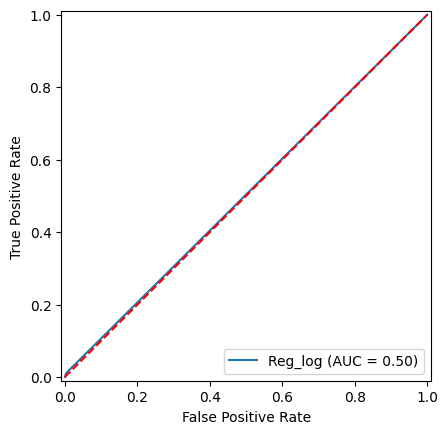

In [91]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test24, y_test_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

In [92]:
#Accuracy
accuracy = accuracy_score(y_test24, y_test_pred)
print("La accuracy del modelo es: %.3f" %accuracy)

La accuracy del modelo es: 0.908


Conclusión: Tanto para el año 2004 como para el 2024, en términos de precisión, los resultados se mantienen iguales. Esto se obtiene tanto al aplicar ambas formas de penalidad. Para todos los casos analizados, parece existir un sobreajuste del modelo debido a que el accuracy del modelo es igual a 1.

5. Realicen un barrido en λ = 10^n con n ∈ {−5, −4, −3 ..., +4, +5} y utilicen 10-fold CV para elegir el λ óptimo en regresión logística con Ridge y con LASSO. ¿Qué λ seleccionó en cada caso? Usando la librería de seaborn, generen box plot mostrando la distribución del error de predicción para cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validación (MSE) para cada partición. Además, para la regularización LASSO, generen un line plot del promedio de la proporción de variables ignoradas por el modelo en función de λ (como vieron en el tutorial 10), es decir la proporción de variables para las cuales el coeficiente asociado es cero

Para 2004

Con penalty=l1

In [118]:
# Definir el rango de valores para C (λ = 1 / C)
param_grid = {'logisticregression__C': [10**n for n in range(-5, 6)]}  # Valores de C desde 10^-5 a 10^5

# Crear el pipeline con StandardScaler y LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear'))

# Configurar la validación cruzada con K=10
cv = StratifiedKFold(n_splits=10)

# Crear GridSearchCV para búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustar el modelo con la validación cruzada y búsqueda de mejores hiperparámetros
grid_search.fit(x_train1_04, y_train04)

# Ver los mejores parámetros encontrados
print("Mejor valor de C (lambda):", grid_search.best_params_['logisticregression__C'])
print("Mejor valor de lambda es:", 1/grid_search.best_params_['logisticregression__C'])
print("Mejor score (neg_mean_squared_error):", grid_search.best_score_)
# Obtener el mejor modelo y evaluarlo en el conjunto de test
best_model = grid_search.best_estimator_

# Predecir las probabilidades y las clases en el conjunto de prueba
y_test_pred_score = best_model.predict_proba(x_test1_04)[:, 1]
y_test_pred = best_model.predict(x_test1_04)

Mejor valor de C (lambda): 10
Mejor valor de lambda es: 0.1
Mejor score (neg_mean_squared_error): -0.13701686746987957


In [119]:
# Imprimir los resultados
print("Probabilidades predichas en el conjunto de prueba:", y_test_pred_score)
print("Clases predichas en el conjunto de prueba:", y_test_pred)

Probabilidades predichas en el conjunto de prueba: [0.14742369 0.23559581 0.11904566 ... 0.01931521 0.0353375  0.19220871]
Clases predichas en el conjunto de prueba: [0 0 0 ... 0 0 0]


In [121]:
coeficientes=best_model.named_steps['logisticregression'].coef_
nombres_caracteristicas = x_train1_24.columns
df_coeficientes = pd.DataFrame(coeficientes, columns=nombres_caracteristicas)
df_coeficientes

,const,CH04,CH06,CH07,CH08,NIVEL_ED,IPCF,MIEMBROS_MAYORES_65,AYUDA_GOBIERNO1,MIEMBROS_MENORES_6
0,0.0,0.242776,-0.168137,0.464484,0.16401,0.166877,-1.419925,-0.01919,0.130575,-0.172012


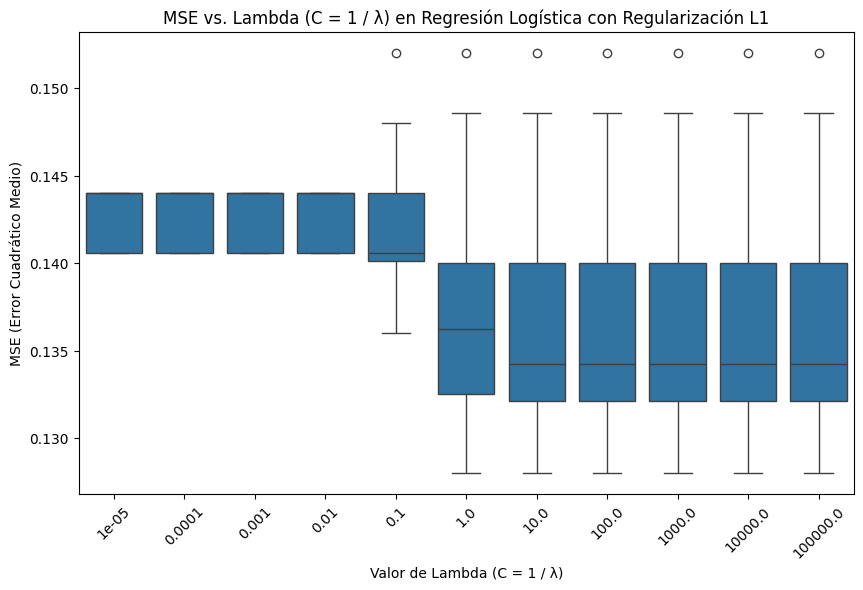

In [120]:
# Extraer los resultados
results = grid_search.cv_results_

# Obtener los MSE de cada pliegue para cada valor de C
# Para eso, necesitamos acceder a los 'split' específicos
mse_values_per_lambda = []

for idx, mean_test_score in enumerate(results['mean_test_score']):
    # Para cada valor de C (lambda), obtener los MSE de cada pliegue
    mse_per_split = results['split0_test_score'][idx]
    for i in range(1, 10):  # Hay 10 pliegues, puedes ajustar el rango si es necesario
        mse_per_split = np.append(mse_per_split, results[f'split{i}_test_score'][idx])

    mse_values_per_lambda.append(mse_per_split)

# Crear un DataFrame con todos los valores de MSE para cada lambda
lambda_values = [10**n for n in range(-5, 6)]
mse_df = pd.DataFrame(mse_values_per_lambda, columns=[f'Pliegue {i+1}' for i in range(10)])
mse_df['Lambda'] = lambda_values

# Convertir los MSE negativos a positivos multiplicando por -1
mse_df.iloc[:, :-1] = -mse_df.iloc[:, :-1]

# Usar melt para reorganizar el DataFrame de forma correcta
mse_melted = mse_df.melt(id_vars='Lambda', var_name='Pliegue', value_name='MSE')

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lambda', y='MSE', data=mse_melted)
plt.title('MSE vs. Lambda (C = 1 / λ) en Regresión Logística con Regularización L1')
plt.xlabel('Valor de Lambda (C = 1 / λ)')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x si es necesario
plt.show()


Con penalty=l2

In [154]:
# Definir el rango de valores para C (λ = 1 / C)
param_grid = {'logisticregression__C': [10**n for n in range(-5, 6)]}  # Valores de C desde 10^-5 a 10^5

# Crear el pipeline con StandardScaler y LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', solver='lbfgs'))

# Configurar la validación cruzada con K=10
cv = StratifiedKFold(n_splits=10)

# Crear GridSearchCV para búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustar el modelo con la validación cruzada y búsqueda de mejores hiperparámetros
grid_search.fit(x_train1_04, y_train04)

# Ver los mejores parámetros encontrados
print("Mejor valor de C (lambda):", grid_search.best_params_['logisticregression__C'])
print("Mejor valor de lambda es:", 1/grid_search.best_params_['logisticregression__C'])
print("Mejor score (neg_mean_squared_error):", grid_search.best_score_)
# Obtener el mejor modelo y evaluarlo en el conjunto de test
best_model = grid_search.best_estimator_

# Predecir las probabilidades y las clases en el conjunto de prueba
y_test_pred_score = best_model.predict_proba(x_test1_04)[:, 1]
y_test_pred = best_model.predict(x_test1_04)

Mejor valor de C (lambda): 10
Mejor valor de lambda es: 0.1
Mejor score (neg_mean_squared_error): -0.13701686746987957


In [155]:
# Imprimir los resultados
print("Probabilidades predichas en el conjunto de prueba:", y_test_pred_score)
print("Clases predichas en el conjunto de prueba:", y_test_pred)

Probabilidades predichas en el conjunto de prueba: [0.14718784 0.23609049 0.11882283 ... 0.01927    0.03539952 0.19204232]
Clases predichas en el conjunto de prueba: [0 0 0 ... 0 0 0]


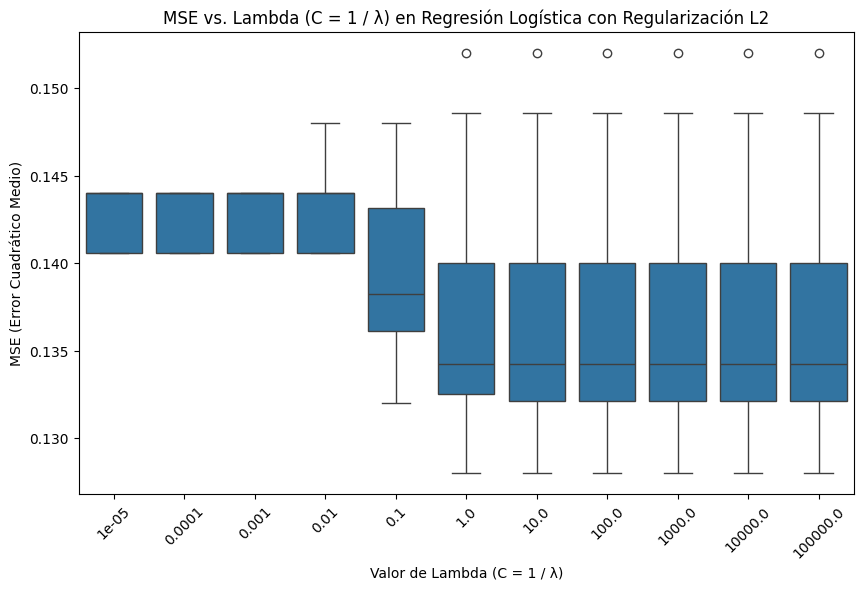

In [156]:
# Extraer los resultados
results = grid_search.cv_results_

# Obtener los MSE de cada pliegue para cada valor de C
# Para eso, necesitamos acceder a los 'split' específicos
mse_values_per_lambda = []

for idx, mean_test_score in enumerate(results['mean_test_score']):
    # Para cada valor de C (lambda), obtener los MSE de cada pliegue
    mse_per_split = results['split0_test_score'][idx]
    for i in range(1, 10):  # Hay 10 pliegues, puedes ajustar el rango si es necesario
        mse_per_split = np.append(mse_per_split, results[f'split{i}_test_score'][idx])

    mse_values_per_lambda.append(mse_per_split)

# Crear un DataFrame con todos los valores de MSE para cada lambda
lambda_values = [10**n for n in range(-5, 6)]
mse_df = pd.DataFrame(mse_values_per_lambda, columns=[f'Pliegue {i+1}' for i in range(10)])
mse_df['Lambda'] = lambda_values

# Convertir los MSE negativos a positivos multiplicando por -1
mse_df.iloc[:, :-1] = -mse_df.iloc[:, :-1]

# Usar melt para reorganizar el DataFrame de forma correcta
mse_melted = mse_df.melt(id_vars='Lambda', var_name='Pliegue', value_name='MSE')

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lambda', y='MSE', data=mse_melted)
plt.title('MSE vs. Lambda (C = 1 / λ) en Regresión Logística con Regularización L2')
plt.xlabel('Valor de Lambda (C = 1 / λ)')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x si es necesario
plt.show()

In [153]:
#Coeficientes asociadas a cada variable
coeficientes=best_model.named_steps['logisticregression'].coef_
nombres_caracteristicas = x_train1_24.columns
df_coeficientes = pd.DataFrame(coeficientes, columns=nombres_caracteristicas)
df_coeficientes

,const,CH04,CH06,CH07,CH08,NIVEL_ED,IPCF,MIEMBROS_MAYORES_65,AYUDA_GOBIERNO1,MIEMBROS_MENORES_6
0,0.0,0.243229,-0.169597,0.463558,0.164657,0.167088,-1.420461,-0.019015,0.130936,-0.172949


Para 2024

Con penalty=l1

In [157]:
# Definir el rango de valores para C (λ = 1 / C)
param_grid = {'logisticregression__C': [10**n for n in range(-5, 6)]}  # Valores de C desde 10^-5 a 10^5

# Crear el pipeline con StandardScaler y LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear'))

# Configurar la validación cruzada con K=10
cv = StratifiedKFold(n_splits=10)

# Crear GridSearchCV para búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustar el modelo con la validación cruzada y búsqueda de mejores hiperparámetros
grid_search.fit(x_train1_24, y_train24)

# Ver los mejores parámetros encontrados
print("Mejor valor de C (lambda):", grid_search.best_params_['logisticregression__C'])
print("Mejor valor de lambda es:", 1/grid_search.best_params_['logisticregression__C'])
print("Mejor score (neg_mean_squared_error):", grid_search.best_score_)
# Obtener el mejor modelo y evaluarlo en el conjunto de test
best_model = grid_search.best_estimator_

# Predecir las probabilidades y las clases en el conjunto de prueba
y_test_pred_score = best_model.predict_proba(x_test1_24)[:, 1]
y_test_pred = best_model.predict(x_test1_24)

Mejor valor de C (lambda): 1e-05
Mejor valor de lambda es: 99999.99999999999
Mejor score (neg_mean_squared_error): -0.08766005068957573


In [158]:
# Imprimir los resultados
print("Probabilidades predichas en el conjunto de prueba:", y_test_pred_score)
print("Clases predichas en el conjunto de prueba:", y_test_pred)

Probabilidades predichas en el conjunto de prueba: [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Clases predichas en el conjunto de prueba: [0 0 0 ... 0 0 0]


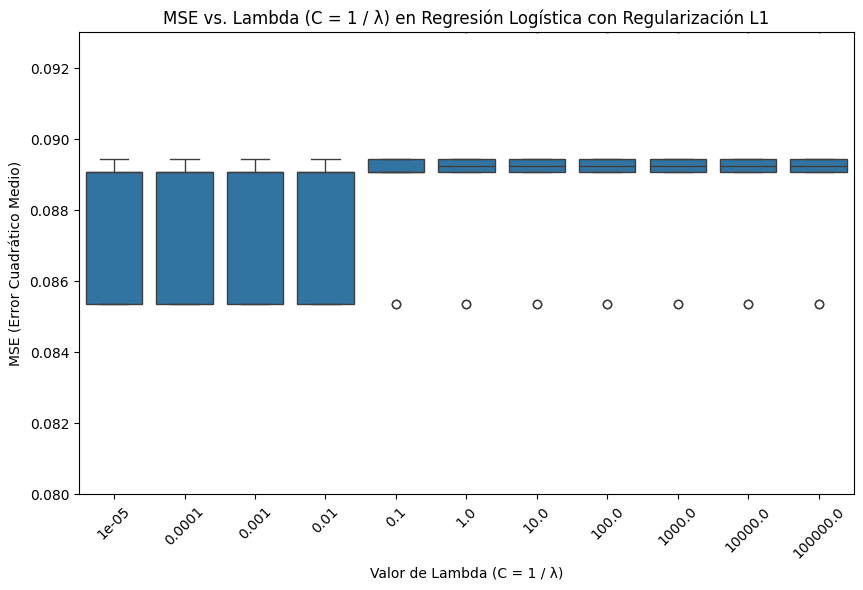

In [159]:
# Extraer los resultados
results = grid_search.cv_results_

# Obtener los MSE de cada pliegue para cada valor de C
# Para eso, necesitamos acceder a los 'split' específicos
mse_values_per_lambda = []

for idx, mean_test_score in enumerate(results['mean_test_score']):
    # Para cada valor de C (lambda), obtener los MSE de cada pliegue
    mse_per_split = results['split0_test_score'][idx]
    for i in range(1, 10):  # Hay 10 pliegues, puedes ajustar el rango si es necesario
        mse_per_split = np.append(mse_per_split, results[f'split{i}_test_score'][idx])

    mse_values_per_lambda.append(mse_per_split)

# Crear un DataFrame con todos los valores de MSE para cada lambda
lambda_values = [10**n for n in range(-5, 6)]
mse_df = pd.DataFrame(mse_values_per_lambda, columns=[f'Pliegue {i+1}' for i in range(10)])
mse_df['Lambda'] = lambda_values

# Convertir los MSE negativos a positivos multiplicando por -1
mse_df.iloc[:, :-1] = -mse_df.iloc[:, :-1]


# Usar melt para reorganizar el DataFrame de forma correcta
mse_melted = mse_df.melt(id_vars='Lambda', var_name='Pliegue', value_name='MSE')

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lambda', y='MSE', data=mse_melted)
plt.title('MSE vs. Lambda (C = 1 / λ) en Regresión Logística con Regularización L1')
plt.xlabel('Valor de Lambda (C = 1 / λ)')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.ylim(0.08, 0.093)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x si es necesario
plt.show()

Con penalty=l2

In [163]:
# Definir el rango de valores para C (λ = 1 / C)
param_grid = {'logisticregression__C': [10**n for n in range(-5, 6)]}  # Valores de C desde 10^-5 a 10^5

# Crear el pipeline con StandardScaler y LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', solver='lbfgs'))

# Configurar la validación cruzada con K=10
cv = StratifiedKFold(n_splits=10)

# Crear GridSearchCV para búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustar el modelo con la validación cruzada y búsqueda de mejores hiperparámetros
grid_search.fit(x_train1_24, y_train24)

# Ver los mejores parámetros encontrados
print("Mejor valor de C (lambda):", grid_search.best_params_['logisticregression__C'])
print("Mejor valor de lambda es:", 1/grid_search.best_params_['logisticregression__C'])
print("Mejor score (neg_mean_squared_error):", grid_search.best_score_)
# Obtener el mejor modelo y evaluarlo en el conjunto de test
best_model = grid_search.best_estimator_

# Predecir las probabilidades y las clases en el conjunto de prueba
y_test_pred_score = best_model.predict_proba(x_test1_24)[:, 1]
y_test_pred = best_model.predict(x_test1_24)

Mejor valor de C (lambda): 1e-05
Mejor valor de lambda es: 99999.99999999999
Mejor score (neg_mean_squared_error): -0.08766005068957573


In [164]:
# Imprimir los resultados
print("Probabilidades predichas en el conjunto de prueba:", y_test_pred_score)
print("Clases predichas en el conjunto de prueba:", y_test_pred)

Probabilidades predichas en el conjunto de prueba: [0.08784094 0.08763197 0.08767468 ... 0.08755763 0.08787818 0.08777346]
Clases predichas en el conjunto de prueba: [0 0 0 ... 0 0 0]


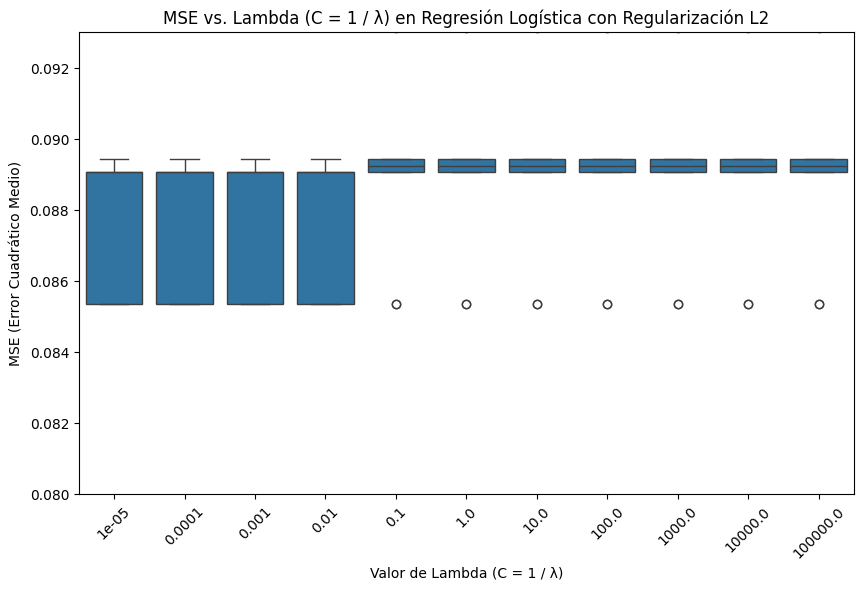

In [165]:
# Extraer los resultados
results = grid_search.cv_results_

# Obtener los MSE de cada pliegue para cada valor de C
# Para eso, necesitamos acceder a los 'split' específicos
mse_values_per_lambda = []

for idx, mean_test_score in enumerate(results['mean_test_score']):
    # Para cada valor de C (lambda), obtener los MSE de cada pliegue
    mse_per_split = results['split0_test_score'][idx]
    for i in range(1, 10):  # Hay 10 pliegues, puedes ajustar el rango si es necesario
        mse_per_split = np.append(mse_per_split, results[f'split{i}_test_score'][idx])

    mse_values_per_lambda.append(mse_per_split)

# Crear un DataFrame con todos los valores de MSE para cada lambda
lambda_values = [10**n for n in range(-5, 6)]
mse_df = pd.DataFrame(mse_values_per_lambda, columns=[f'Pliegue {i+1}' for i in range(10)])
mse_df['Lambda'] = lambda_values

# Convertir los MSE negativos a positivos multiplicando por -1
mse_df.iloc[:, :-1] = -mse_df.iloc[:, :-1]

# Usar melt para reorganizar el DataFrame de forma correcta
mse_melted = mse_df.melt(id_vars='Lambda', var_name='Pliegue', value_name='MSE')

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lambda', y='MSE', data=mse_melted)
plt.title('MSE vs. Lambda (C = 1 / λ) en Regresión Logística con Regularización L2')
plt.xlabel('Valor de Lambda (C = 1 / λ)')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.ylim(0.08, 0.093)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x si es necesario
plt.show()


In [166]:
# Coeficientes asociadas a cada variable
coeficientes=best_model.named_steps['logisticregression'].coef_
nombres_caracteristicas = x_train1_24.columns
df_coeficientes = pd.DataFrame(coeficientes, columns=nombres_caracteristicas)
df_coeficientes

,const,CH04,CH06,CH07,CH08,NIVEL_ED,IPCF,MIEMBROS_MAYORES_65,AYUDA_GOBIERNO1,MIEMBROS_MENORES_6
0,0.0,0.000276,-0.000947,0.000808,0.001128,-0.0005,-0.000445,0.000119,0.000415,-0.000083
